In [54]:
import numpy as np
import gym
import gym.spaces as spaces
import gym.envs as envs
import time
import matplotlib.pyplot as plt

In [55]:
# Setting of Environment
N = 1000
env = gym.make('NChain-v0', n=N, large=2000, small=2, slip=0.2)

env.nS = env.observation_space.n
env.nA = env.action_space.n

# P[state][action] = prob, reward, s_prime
env.P = np.zeros((env.nS, env.nA, env.nA, 3)) 
for s in range(env.nS):
    if s == env.nS - 1 :
        env.P[s][0] = [ [(1-env.slip), env.large, s], [env.slip, env.small, 0] ]
        env.P[s][1] = [ [env.slip, env.large, s], [1 - env.slip, env.small, 0] ]
        continue
    # Forward
    env.P[s][0] = [ [(1-env.slip), 0 if s < env.nS - 1 else env.large, s+1], [env.slip, env.small, 0] ]
    # Backward
    env.P[s][1] = [ [env.slip, 0 if s < env.nS - 1 else env.large, s+1], [1 - env.slip, env.small, 0] ]

### Helper functions

In [56]:
def map_actions(optimal_policy):
    policy = []
    for i in optimal_policy:
        if i == 0: # Forward
            policy.append('F')
        elif i == 1: # Backward
            policy.append('B')
    return policy

In [57]:
# Policy Analysis

def get_score(env, policy, max_timestep=200, episodes=1000):
    R = np.zeros((episodes, max_timestep))
    A = np.zeros((episodes, max_timestep))
    ended = 0
    reached = []
    for ep in range(episodes):
        s = env.reset()
        for i in range(max_timestep):
            a = policy[s]
            A[ep][i] = a
            s_prime, reward, _, _ = env.step(a)
            R[ep][i] = reward
            s = s_prime
        if env.large in R[ep]:
            ended += 1
            reached.append(ep)
    
    total_R = np.sum(R, axis=1)
    max_r = np.max(total_R)
    min_r = np.min(total_R)
    avg_r = np.mean(total_R)
    print("Number of episodes reached end = ", ended, " out of ", episodes, " episodes." )
    if len(reached) > 0:
        print("Max reward where episode reached end = ", np.max(total_R[reached]))
        print("Min reward where episode reached end = ", np.min(total_R[reached]))
    print("Max Reward = ", max_r)
    print("Avg Reward = ", avg_r)
    print("Min Reward = ", min_r)
    
    return R, A

### Value Iteration
- Procedure Value_Iteration(S,A,P,R,θ):
           Inputs
                     S is the set of all states
                     A is the set of all actions
                     P is state transition function specifying P(s'|s,a)
                     R is a reward function R(s,a,s')
                     θ a threshold, θ>0
           Output
                     π[S] approximately optimal policy
                    V[S] value function
           Local
                     real array Vk[S] is a sequence of value functions
                     action array π[S]
           assign V0[S] arbitrarily
           k ←0
           repeat
                     k ←k+1
                     for each state s do
                               Vk[s] = maxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk-1[s'])
           until ∀s |Vk[s]-Vk-1[s]| < θ
           for each state s do
                     π[s] = argmaxa ∑s' P(s'|s,a) (R(s,a,s')+ γVk[s'])
           return π,Vk

In [58]:
def get_action_values(env, s, V, gamma=0.99):
    action_values = np.zeros(env.nA)
    
    for a in range(env.nA):
        for prob, reward, s_prime in env.P[s][a]:
            action_values[a] += prob * ( reward + gamma * V[int(s_prime)])
            
    return action_values

In [77]:
'''Value Iteration'''
def value_iteration(env, gamma = 0.999, max_iteration = 1000):
    # Initialise Utility Function
    V = np.zeros(env.nS)

    for i in range(max_iteration):
        prev_V = np.copy(V)

        #loop over all states
        for s in range(env.nS):
            action_values = get_action_values(env, s, prev_V, gamma)
            best_action_value = np.max(action_values)
            V[s] = best_action_value

        if i%100 == 0 and np.all(np.isclose(V, prev_V, rtol=0.00)):
            print("Value converged at iteration ", i)
            break

    optimal_policy = np.zeros(env.nS, dtype = 'int8')
    for s in range(env.nS):
        s_action_value = get_action_values(env, s, V, gamma)
        optimal_policy[s] = np.argmax(s_action_value)

    return V, optimal_policy

### Test Value Iteration 

Number of states:  2
Number of actions:  1000
Value converged at iteration  18900
Time to converge:  2.66e+02 s
Optimal Value function: 
[1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.9999902  1599.9999902  1599.9999902  1599.9999902
 1599.9999902  1599.999

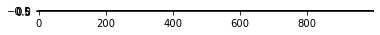

In [78]:
env.reset()
print("Number of states: ", env.action_space.n)
print("Number of actions: ", env.observation_space.n)

start_time = time.time()
optimal_value, optimal_policy = value_iteration(env, gamma=0.999, max_iteration=100000 )
stop_time = time.time()
time_taken = (stop_time - start_time)

print (f"Time to converge: {time_taken : 0.3} s")

print('Optimal Value function: ')
print(optimal_value)
plt.imshow(optimal_value.reshape(1,N), cmap='gray')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(policy)

In [79]:
# R, A = get_score(env, optimal_policy, max_timestep=20, episodes=5000)

# R, A = get_score(env, optimal_policy, max_timestep=100, episodes=5000)

R, A = get_score(env, optimal_policy, max_timestep=1000, episodes=5000)

Number of episodes reached end =  0  out of  5000  episodes.
Max Reward =  1696.0
Avg Reward =  1600.4972
Min Reward =  1506.0


### Policy Iteration
The policy iteration algorithm manipulates the policy directly, rather than finding it indirectly via the optimal value function. It operates as follows:

<img src='http://incompleteideas.net/book/first/ebook/pseudotmp1.png'>
<img src='http://incompleteideas.net/book/first/ebook/imgtmp35.png'>

In [62]:
def get_policy_val(env, policy, V, gamma):
    policy_values = np.zeros(env.nS)
    for s, a in zip(range(len(policy)), policy):
        for prob, reward, s_prime in env.P[s][a]:
            policy_values[s] += prob * (reward + gamma * V[int(s_prime)])
            
    return policy_values

In [63]:
def policy_iteration(env, gamma = 0.99, max_iteration = 1000):
    V = np.zeros(env.nS)
    
    P = np.random.randint(0, env.nA, env.nS)
    prev_P = np.copy(P)
    
    for i in range(max_iteration):
        
        V = get_policy_val(env, P, V, gamma)
        
        for s in range(env.nS):
            s_action_value = get_action_values(env, s, V, gamma)
            P[s] = np.argmax(s_action_value)
        
        if i % 10 == 0:
            if np.all(np.equal(P, prev_P)):
                print("Policy converged at iteration ", i)
                break
            prev_P = np.copy(P)
        
    return V, P

### Testing Policy Iteration

### env.reset()
print("Number of states: ", env.action_space.n)
print("Number of actions: ", env.observation_space.n)

start_time = time.time()
optimal_value, optimal_policy = policy_iteration(env, gamma=0.999, max_iteration=1000)
stop_time = time.time()
time_taken = (stop_time - start_time)

print (f"Time to converge: {time_taken : 0.3} s")

print('Optimal Value function: ')
print(optimal_value)

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(policy)

In [65]:
# R, A = get_score(env, optimal_policy, max_timestep=20, episodes=5000)

# R, A = get_score(env, optimal_policy, max_timestep=100, episodes=5000)

R, A = get_score(env, optimal_policy, max_timestep=1000, episodes=5000)

Number of episodes reached end =  0  out of  5000  episodes.
Max Reward =  1686.0
Avg Reward =  1600.0176
Min Reward =  1484.0


## Q- Learning

In [116]:
import random
env.reset()
action_size = env.action_space.n
state_size = env.observation_space.n

qtable = np.zeros((state_size, action_size))
T = np.zeros((state_size, action_size, state_size))
T_Count = T.copy()
R = qtable.copy()

total_episodes = 1000000        # Total episodes
learning_rate = 0.8           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.99                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005

In [117]:
# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
                
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

Score over time: 152.959952
[[117.71896344 123.14686817]
 [115.51120467 120.86174401]
 [117.03583756 118.38715033]
 ...
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]]


Optimal Value function: 
[123.147 120.862 118.387 120.867 121.603 116.826 109.665 114.653 115.823
 119.416 118.271 114.046 110.76  118.841 113.35   82.403 101.578  62.579
  27.33    8.289  76.767  19.251  74.945  56.42   37.881  68.43  109.495
 107.319  77.976 112.823   0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.   

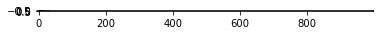

In [118]:
optimal_policy = np.argmax(qtable, axis=1)
optimal_value = np.amax(qtable, axis=1)

print('Optimal Value function: ')
print(np.round(optimal_value, 3))
plt.imshow(optimal_value.reshape((1, N)), cmap='gist_gray_r')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(np.array(policy))

In [119]:
# R, A = get_score(env, optimal_policy, max_timestep=20, episodes=5000)

# R, A = get_score(env, optimal_policy, max_timestep=100, episodes=5000)

R, A = get_score(env, optimal_policy, max_timestep=1000, episodes=5000)

Number of episodes reached end =  0  out of  5000  episodes.
Max Reward =  1676.0
Avg Reward =  1599.6588
Min Reward =  1476.0


import random
env.reset()
action_size = env.action_space.n
state_size = env.observation_space.n

qtable = np.zeros((state_size, action_size))
T = np.zeros((state_size, action_size, state_size))
T_Count = T.copy()
R = qtable.copy()

total_episodes = 10000        # Total episodes
learning_rate = 0.8           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001

# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    state = env.reset()
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state,:])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
                
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))
print(qtable)

optimal_policy = np.argmax(qtable, axis=1)
optimal_value = np.amax(qtable, axis=1)

print('Optimal Value function: ')
print(np.round(optimal_value, 3))
plt.imshow(optimal_value.reshape((1, N)), cmap='gist_gray_r')

print('Final Policy: ')
policy = map_actions(optimal_policy)

print(np.array(policy))

R, A = get_score(env, optimal_policy, max_timestep=20, episodes=5000)

R, A = get_score(env, optimal_policy, max_timestep=100, episodes=5000)

R, A = get_score(env, optimal_policy, max_timestep=500, episodes=5000)